In [1]:
import torch
from datasets import load_dataset
from transformers import AutoTokenizer
from torch.utils.data import TensorDataset


# Load the dataset and tokenizer
dataset = load_dataset("imdb")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Tokenize the dataset
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True, return_tensors="pt", max_length=512)

train_dataset = dataset["train"].map(tokenize, batched=True, batch_size=len(dataset["train"]))
val_dataset = dataset["test"].map(tokenize, batched=True, batch_size=len(dataset["test"]))

# Extract input_ids and attention_mask from the tokenized dataset
train_data = torch.tensor(train_dataset["input_ids"])
train_attention_mask = torch.tensor(train_dataset["attention_mask"])
train_labels = torch.tensor(train_dataset["label"])

val_data = torch.tensor(val_dataset["input_ids"])
val_attention_mask = torch.tensor(val_dataset["attention_mask"])
val_labels = torch.tensor(val_dataset["label"])

# Create TensorDatasets
train_dataset = TensorDataset(train_data, train_attention_mask, train_labels)
val_dataset = TensorDataset(val_data, val_attention_mask, val_labels)

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

a:\research\pytorch-examples\.venv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [5]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

In [6]:
def get_device():
  device="cpu"
  if torch.cuda.is_available():
    device="cuda"
  elif  torch.backends.mps.is_available():
    device='mps'
  else:
    device="cpu"
  return device


device = get_device()
print(device)

cpu


In [8]:
class PositionalEncoding(nn.Module):
    def __init__(self, dim_embedding, dropout=0.1, max_seq_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        postional_encoding = torch.zeros(max_seq_len, dim_embedding)
        position = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
        denom_term = torch.exp(torch.arange(0, dim_embedding, 2).float() * (-math.log(10000.0) / dim_embedding))
        postional_encoding[:, 0::2] = torch.sin(position * denom_term)
        postional_encoding[:, 1::2] = torch.cos(position * denom_term)
        postional_encoding = postional_encoding.unsqueeze(0).transpose(0, 1)
        self.register_buffer('postional_encoding', postional_encoding)
    def forward(self, x):
        x = x + self.postional_encoding[:x.size(0), :]
        return self.dropout(x)

In [12]:
from torch.utils.data import DataLoader

In [13]:
def collate_fn(batch):
    input_ids, attention_mask, labels = zip(*batch)
    input_ids = torch.stack(input_ids).transpose(0, 1)  # Transpose input_ids
    attention_mask = torch.stack(attention_mask)   # Transpose attention_mask
    labels = torch.nn.functional.one_hot(torch.tensor(labels), num_classes=2).float().to(device)
    return input_ids, attention_mask, labels

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [15]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 26421880/26421880 [00:04<00:00, 6325430.14it/s]


Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 939919.23it/s]


Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4829212.91it/s]


Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<?, ?it/s]

Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw



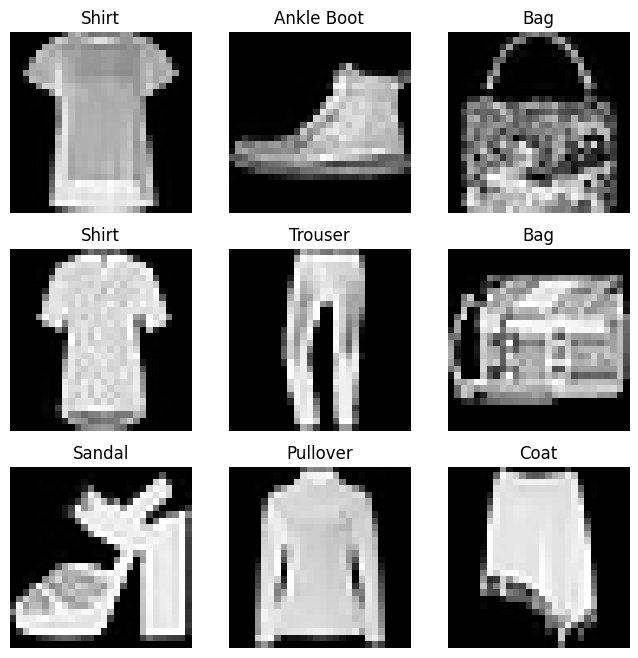

In [16]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [17]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [18]:
def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
    self.img_labels = pd.read_csv(annotations_file)
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform

In [19]:
def __len__(self):
    return len(self.img_labels)

In [20]:
def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
    image = read_image(img_path)
    label = self.img_labels.iloc[idx, 1]
    if self.transform:
        image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)
    return image, label



In [21]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


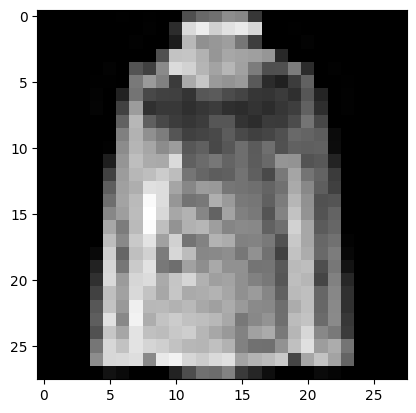

Label: 4


In [22]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")